**TEAM : -**
**CS23MTECH11024 - ARIF KHAN PATHAN,**
**CS23MTECH11033 - SANKET RATHOD ,**
**CS23MTECH11034 - SANKET DEONE ,**
**CS23MTECH11022 - AKSHAY KUMAR ,**
**CS23MTECH11021 - ABHISHREE GAJANAN KHANGAR ,**

**Fraud Detection using variational autoencodeing**

In [91]:
import pandas as pd
import numpy as np
import os

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# SKLearn related libraries
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Keras NN related libraries
from keras import layers
from keras.layers import Input, Dense
from keras.models import Model, Sequential 
from keras import regularizers

**Loading Dataset**

In [92]:
file = 'C:\\Users\\Arif\\Desktop\\Fruad Assg\\creditcard.csv'

# print(os.path.exists(file))

# Load the data
df = pd.read_csv(file, header=0)

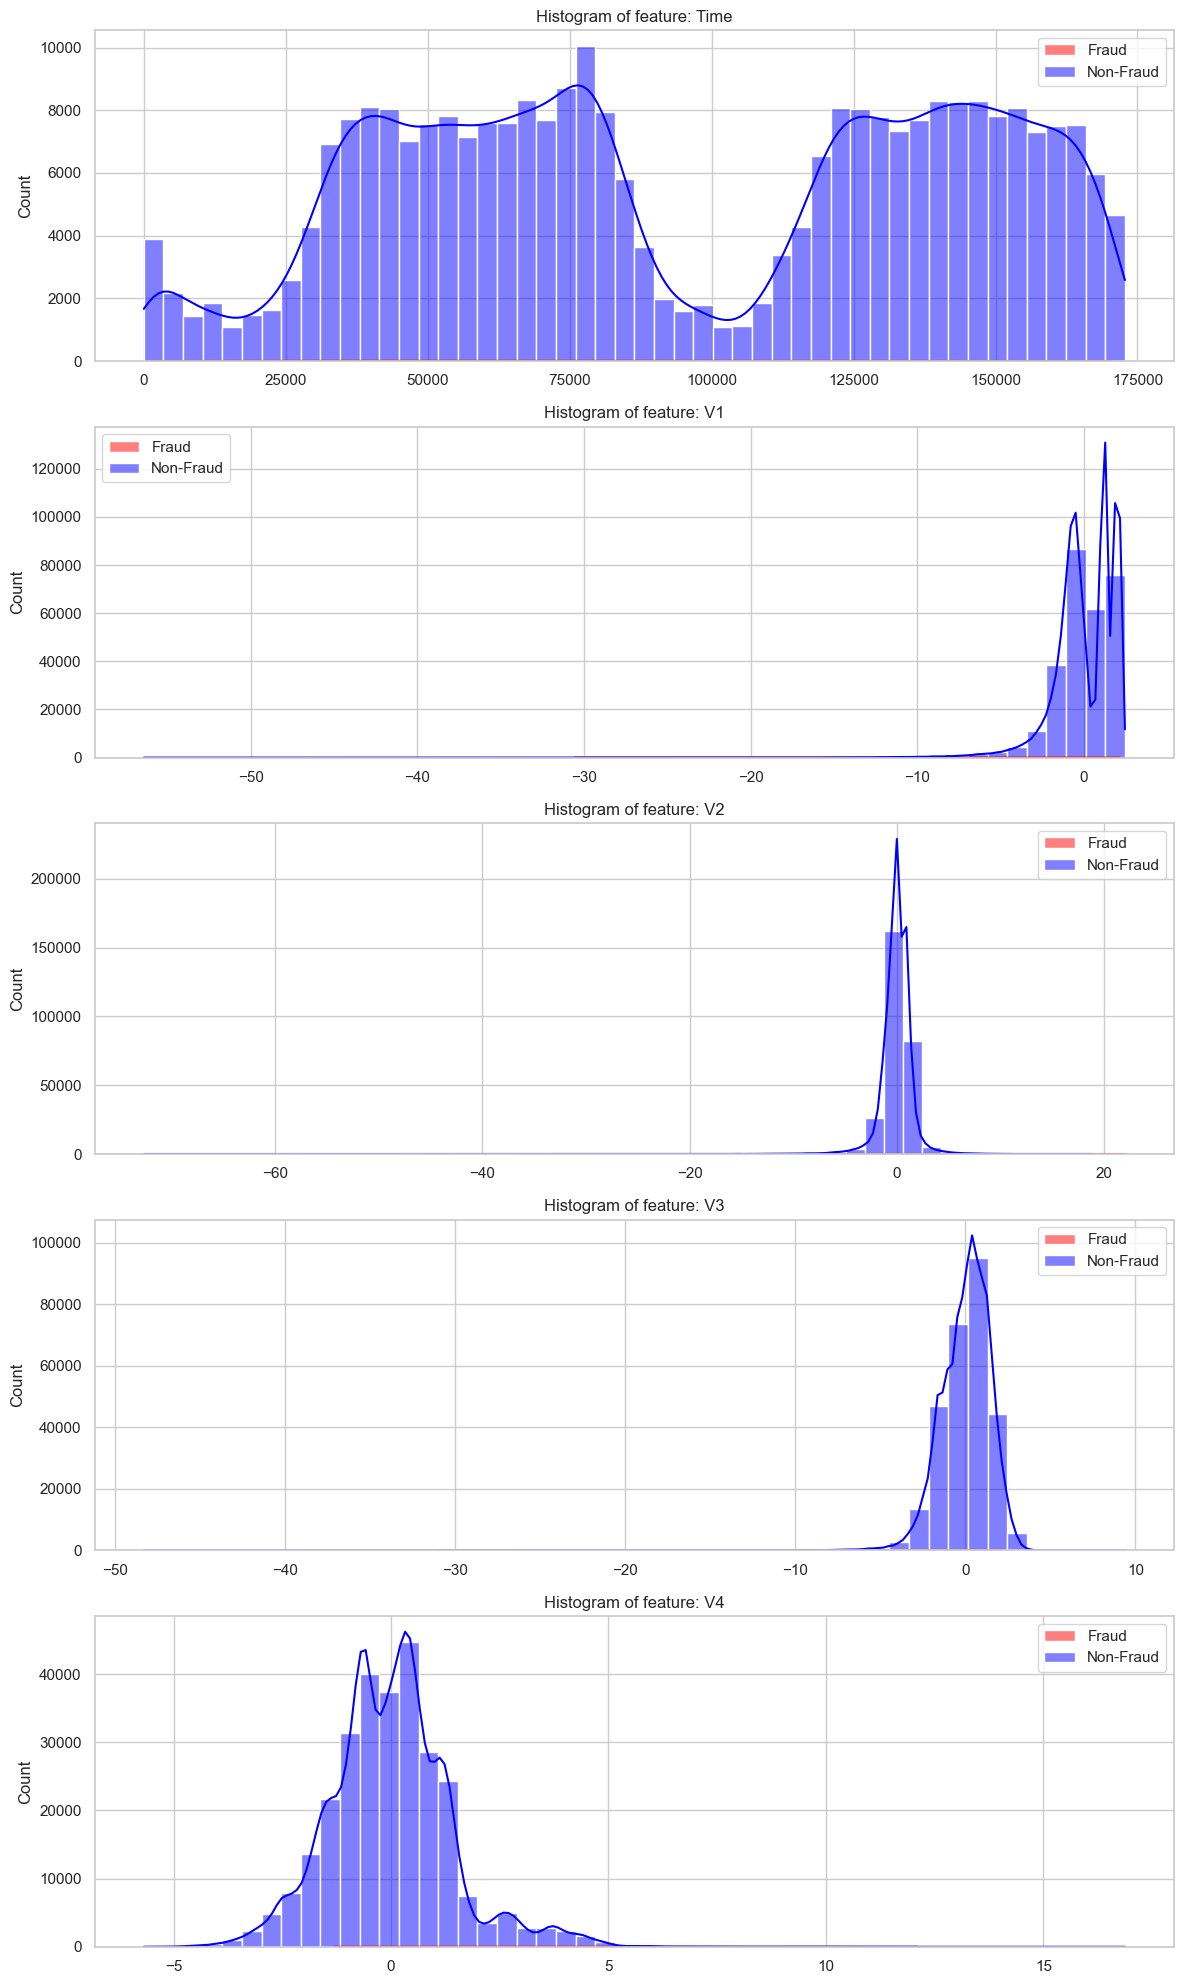

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
%matplotlib inline

plt.figure(figsize=(12,5*4))
gs = gridspec.GridSpec(5, 1)

for i, cn in enumerate(df.columns[:5]):
    ax = plt.subplot(gs[i])
    sns.histplot(df[cn][df.Class == 1], bins=50, ax=ax, kde=True, label='Fraud', color='red')
    sns.histplot(df[cn][df.Class == 0], bins=50, ax=ax, kde=True, label='Non-Fraud', color='blue')
    ax.set_xlabel('')
    ax.set_title('Histogram of feature: ' + str(cn))
    ax.legend()

plt.tight_layout()
plt.show()


In [94]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [95]:
# Convert 'Time' and 'Amount' features to log scale
df['Time'] = np.log1p(df['Time'])
df['Amount'] = np.log1p(df['Amount'])


In [96]:
# Sampling of data
normal = df[df['Class'] == 0].sample(4000)
fraud = df[df['Class'] == 1]

In [97]:
datasetSubset = pd.concat([normal, fraud], ignore_index=True)

**Split the Dataset**

In [98]:
# Splitting the dataset into X and y features
y = datasetSubset['Class']
X = datasetSubset.drop('Class', axis=1)

**Visualizing dataset**

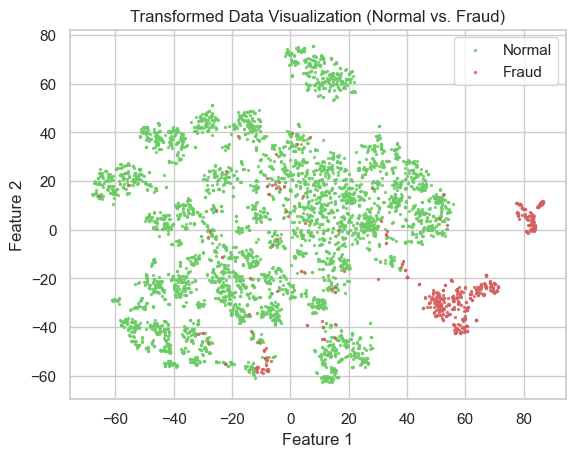

In [99]:
import matplotlib.pyplot as plt
import numpy as np  
import seaborn as sns
from sklearn.manifold import TSNE


# Initializing TSNE object with 2 principal components
tsne = TSNE(n_components=2, random_state=0)
X_transformed = tsne.fit_transform(X)

# Filter data based on class labels
normal_indices = np.where(y == 0)[0]
fraud_indices = np.where(y == 1)[0]

# Create the scatter plot
#plt.figure(figsize=(12, 8))

plt.scatter(X_transformed[normal_indices, 0], X_transformed[normal_indices, 1],  
            marker='o', color='g', linewidth=1, alpha=0.8, label='Normal',s=2)
plt.scatter(X_transformed[fraud_indices, 0], X_transformed[fraud_indices, 1],   
            marker='o', color='r', linewidth=1, alpha=0.8, label='Fraud',s=2)

plt.legend(loc='best')
plt.title('Transformed Data Visualization (Normal vs. Fraud)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.show()

**scaling of data**

In [100]:
scaler = StandardScaler().fit_transform(X)

X_normal = scaler[y == 0]
X_fraud = scaler[y == 1]

In [101]:
latent_dim =2

**setting up the VAE model**

In [102]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class Sampling(nn.Module):
    def __init__(self):
        super(Sampling, self).__init__()

    def forward(self, mean, log_var):
        epsilon = torch.randn_like(log_var)
        return mean + torch.exp(0.5 * log_var) * epsilon

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 96),
            nn.ReLU(),
            nn.Linear(96, 48),
            nn.ReLU(),
            nn.Linear(48, 24),
            nn.ReLU(),
            nn.Linear(24, 12),
            nn.ReLU()
        )

        self.mean_layer = nn.Linear(12, latent_dim)
        self.log_var_layer = nn.Linear(12, latent_dim)

        self.sampling = Sampling()

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 12),
            nn.ReLU(),
            nn.Linear(12, 24),
            nn.ReLU(),
            nn.Linear(24, 48),
            nn.ReLU(),
            nn.Linear(48, 96),
            nn.ReLU(),
            nn.Linear(96, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        mean = self.mean_layer(x)
        log_var = self.log_var_layer(x)
        z = self.sampling(mean, log_var)
        reconstructed = self.decoder(z)
        return reconstructed, mean, log_var

# Define the input dimension and latent dimension
input_dim = X.shape[1]
latent_dim = 2

# Instantiate the VAE model
vae = VAE(input_dim, latent_dim)

# Define the KL divergence loss function
def kl_divergence_loss(mean, log_var):
    return -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

# Define the reconstruction loss function (MSE)
mse_loss = nn.MSELoss()

# Define the optimizer
optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)

# Define lists to store training history
train_losses = []

# Training loop
epochs = 50
batch_size = 64

for epoch in range(epochs):
    epoch_loss = 0.0  # Initialize epoch loss

    # Iterate over batches
    for i in range(0, len(X_normal), batch_size):
        batch_x = torch.FloatTensor(X_normal[i:i + batch_size])
        optimizer.zero_grad()
        recon_batch, mean, log_var = vae(batch_x)
        loss = mse_loss(recon_batch, batch_x) + kl_divergence_loss(mean, log_var)
        loss.backward()
        optimizer.step()

        # Accumulate batch loss for this epoch
        epoch_loss += loss.item()

    # Calculate average epoch loss
    avg_epoch_loss = epoch_loss / len(X_normal)
    train_losses.append(avg_epoch_loss)  # Append to training history

    # Print training progress
    print(f"Epoch [{epoch + 1}/{epochs}], Avg. Loss: {avg_epoch_loss:.4f}")

# After training, `train_losses` will contain the history of losses for each epoch



Epoch [1/50], Avg. Loss: 0.0149
Epoch [2/50], Avg. Loss: 0.0086
Epoch [3/50], Avg. Loss: 0.0085
Epoch [4/50], Avg. Loss: 0.0085
Epoch [5/50], Avg. Loss: 0.0085
Epoch [6/50], Avg. Loss: 0.0085
Epoch [7/50], Avg. Loss: 0.0085
Epoch [8/50], Avg. Loss: 0.0085
Epoch [9/50], Avg. Loss: 0.0085
Epoch [10/50], Avg. Loss: 0.0085
Epoch [11/50], Avg. Loss: 0.0085
Epoch [12/50], Avg. Loss: 0.0085
Epoch [13/50], Avg. Loss: 0.0085
Epoch [14/50], Avg. Loss: 0.0085
Epoch [15/50], Avg. Loss: 0.0085
Epoch [16/50], Avg. Loss: 0.0085
Epoch [17/50], Avg. Loss: 0.0085
Epoch [18/50], Avg. Loss: 0.0085
Epoch [19/50], Avg. Loss: 0.0085
Epoch [20/50], Avg. Loss: 0.0085
Epoch [21/50], Avg. Loss: 0.0085
Epoch [22/50], Avg. Loss: 0.0085
Epoch [23/50], Avg. Loss: 0.0085
Epoch [24/50], Avg. Loss: 0.0085
Epoch [25/50], Avg. Loss: 0.0085
Epoch [26/50], Avg. Loss: 0.0085
Epoch [27/50], Avg. Loss: 0.0085
Epoch [28/50], Avg. Loss: 0.0085
Epoch [29/50], Avg. Loss: 0.0085
Epoch [30/50], Avg. Loss: 0.0085
Epoch [31/50], Avg.

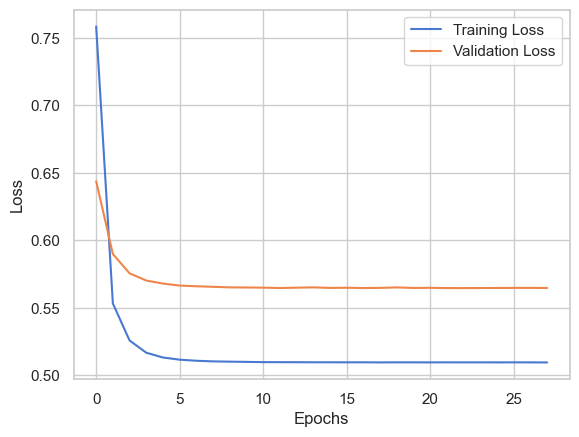

In [103]:

import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [104]:
# Assuming X_normal and X_fraud are torch tensors, you can do:
normal_tran_points, _, _ = vae(torch.FloatTensor(X_normal))
fraud_tran_points, _, _ = vae(torch.FloatTensor(X_fraud))

# Convert the tensors to numpy arrays if needed
normal_tran_points = normal_tran_points.detach().numpy()
fraud_tran_points = fraud_tran_points.detach().numpy()

In [105]:
encoded_X = np.append(normal_tran_points, fraud_tran_points, axis=0)
y_normal = np.zeros(normal_tran_points.shape[0])
y_fraud = np.ones(fraud_tran_points.shape[0])
encoded_y = np.append(y_normal, y_fraud, axis=0)

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
X_enc_train, X_enc_test, y_enc_train, y_enc_test = train_test_split(encoded_X, encoded_y, test_size=0.4)

In [107]:
import torch

# Convert the DataFrame to a PyTorch tensor
X_test_tensor = torch.FloatTensor(X_test.values)

# Use the trained VAE model to reconstruct the test data
reconstructed_data, _, _ = vae(X_test_tensor)
reconstructed_data = reconstructed_data.detach().numpy()

# Calculate the reconstruction error (MSE) between original and reconstructed data
mse = np.mean(np.square(X_test.values - reconstructed_data), axis=1)

# Set a threshold for anomaly detection (you can experiment with different thresholds)
threshold = 9

# Classify transactions as normal (0) or fraudulent (1) based on the threshold
predictions = (mse > threshold).astype(int)

# Print the number of normal and fraudulent transactions
print("Number of normal transactions:", np.sum(predictions == 0))
print("Number of fraudulent transactions:", np.sum(predictions == 1))

# Evaluate the performance using F1 score
from sklearn.metrics import f1_score, precision_score, recall_score

f1 = f1_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)

print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)


Number of normal transactions: 1630
Number of fraudulent transactions: 167
F1 Score: 0.7784090909090908
Precision: 0.8203592814371258
Recall: 0.7405405405405405


**Conclusion**

*VAE has performed better as compared to the autoencoder *